In [2]:
from scipy.integrate import quad
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def load_data_with_names(file_path):
    """
    Load data from a file and associate each row with its corresponding name.

    Parameters:
        file_path (str): Path to the file.

    Returns:
        dict: A dictionary where keys are row names and values are the corresponding data arrays.
    """
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Initialize the dictionary to store data
    data_dict = {}

    # Iterate through the lines to extract names and data
    for i in range(len(lines)):
        line = lines[i].strip()
        if line.startswith("#"):  # Check if the line starts with '#'
            # Extract the name (remove the '#' and strip whitespace)
            row_name = line[1:].strip()
            # The next line contains the numerical data
            if i + 1 < len(lines):
                data = list(map(float, lines[i + 1].strip().split()))
                data_dict[row_name] = data

    return data_dict

In [3]:
file_path = "/home/adriana/python/galIMF/simulation_results_from_galaxy_evol/imfKroupaSTF0.5alpha2.35SFR0.1SFEN9Z_0-15.98/chemical_and_SN_evolution.txt"
data = load_data_with_names(file_path)

# Access specific rows by name
logNO = data['Stellar mass-weighted [N/O]:']
logOH = data['Stellar mass-weighted [O/H]:']
logCO = data['Stellar mass-weighted [C/O]:']
timestep = data['time step list:']
sfh = np.loadtxt("SFH.txt")

<>:8: SyntaxWarning: invalid escape sequence '\o'
<>:8: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_10047/1751333923.py:8: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel('SFR (M$_\odot$ yr$^{-1}$)', fontsize=14)


Text(0.5, 1.0, 'Star Formation History')

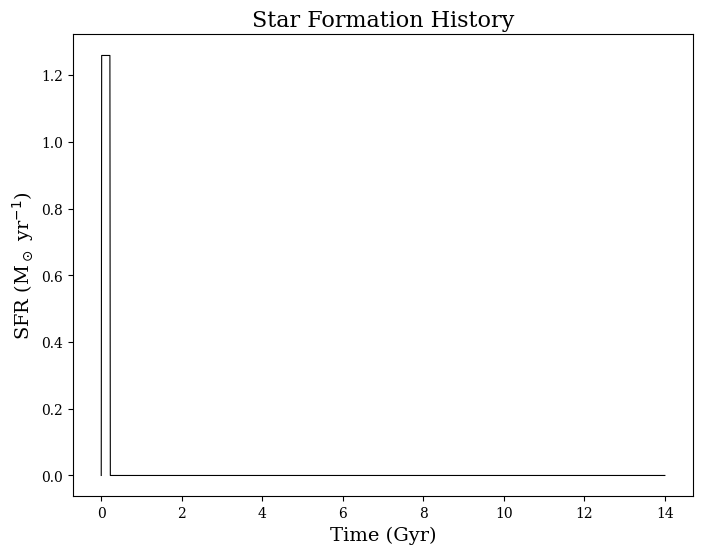

In [4]:
#plot sfh
time = np.linspace(0, max(timestep), sfh.size)/1e9

plt.rc('font', family='serif')
plt.figure(figsize=(8, 6))
plt.plot(time, sfh, color='k', lw=0.8)
plt.xlabel('Time (Gyr)', fontsize=14)
plt.ylabel('SFR (M$_\odot$ yr$^{-1}$)', fontsize=14)
plt.title('Star Formation History', fontsize=16)

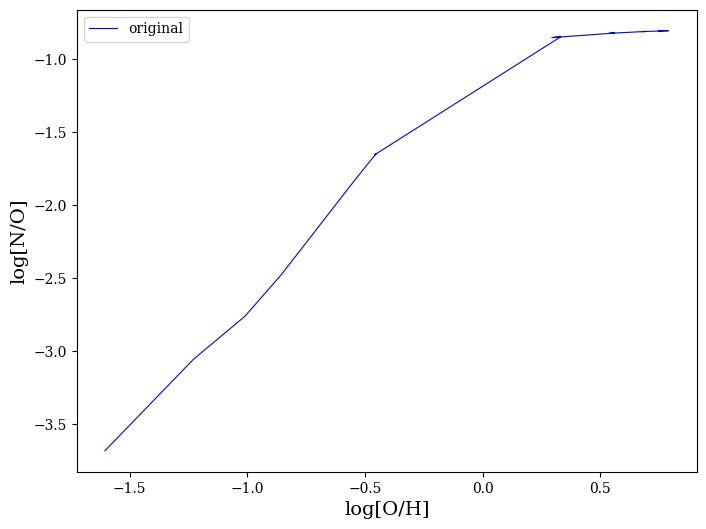

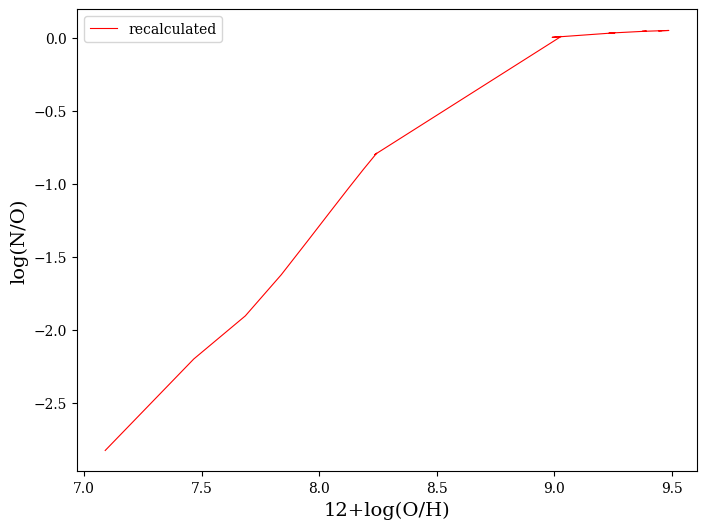

In [5]:
plt.rc('font', family='serif')
plt.figure(figsize=(8, 6))
plt.plot(logOH[3:], logNO[3:], color='b', lw=0.8, label='original')
plt.xlabel('log[O/H]', fontsize=14)
plt.ylabel('log[N/O]', fontsize=14)
plt.legend()
plt.savefig('logOH_logNO.png', dpi=300)
plt.show()
plt.figure(figsize=(8, 6))
logNOrec = [i + 0.86 for i in logNO]
logOHrec = [i +8.696 for i in logOH]
plt.plot(logOHrec[3:], logNOrec[3:], color='r', lw=0.8, label='recalculated')
plt.xlabel('12+log(O/H)', fontsize=14)
plt.ylabel('log(N/O)', fontsize=14)
plt.legend()
plt.savefig('logOH_logNO_recalculated.png', dpi=300)

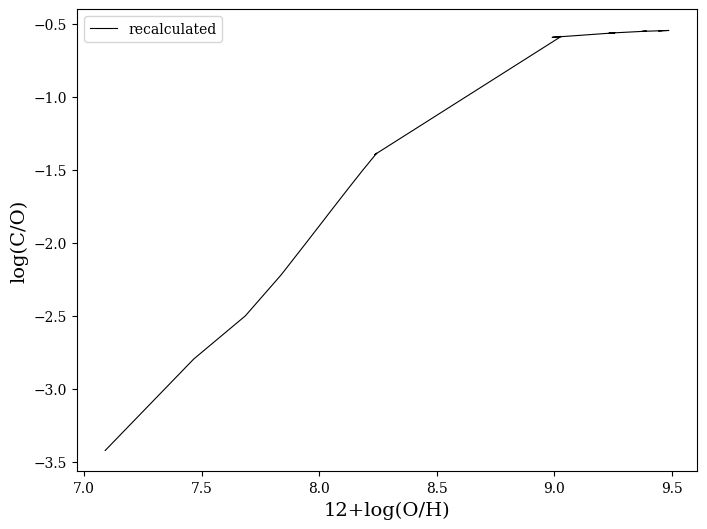

In [6]:
plt.rc('font', family='serif')
plt.figure(figsize=(8, 6))
logCOrec = [i + 0.26 for i in logNO]
plt.plot(logOHrec[3:], logCOrec[3:], color='k', lw=0.8, label='recalculated')
plt.xlabel('12+log(O/H)', fontsize=14)
plt.ylabel('log(C/O)', fontsize=14)
plt.legend()
plt.savefig('logOH_logNO_recalculated.png', dpi=300)

In [4]:
path = "/home/adriana/python/galIMF/simulation_results_from_galaxy_evol/imfSalpeterSTF0.097alpha2.35SFR0.1SFEN0.66Z_0-0.15/chemical_and_SN_evolution.txt"
M5 = load_data_with_names(path)

# Access specific rows by name
logNOM5 = M5['Stellar mass-weighted [N/O]:']
logOHM5 = M5['Stellar mass-weighted [O/H]:']
timestepM5 = M5['time step list:']
sfh = np.loadtxt("SFH.txt")

<>:8: SyntaxWarning: invalid escape sequence '\o'
<>:8: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_11607/97045245.py:8: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel('SFR (M$_\odot$ yr$^{-1}$)', fontsize=14)


Text(0.5, 1.0, 'Star Formation History')

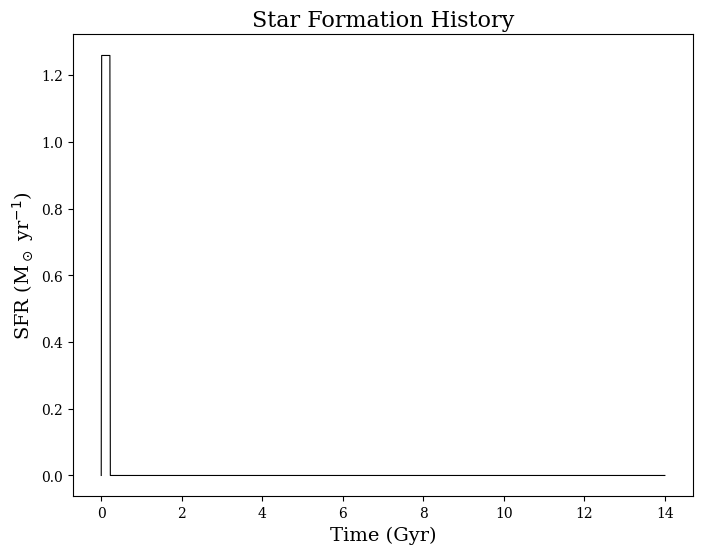

In [5]:
#plot sfh
time = np.linspace(0, max(timestepM5), sfh.size)/1e9

plt.rc('font', family='serif')
plt.figure(figsize=(8, 6))
plt.plot(time, sfh, color='k', lw=0.8)
plt.xlabel('Time (Gyr)', fontsize=14)
plt.ylabel('SFR (M$_\odot$ yr$^{-1}$)', fontsize=14)
plt.title('Star Formation History', fontsize=16)

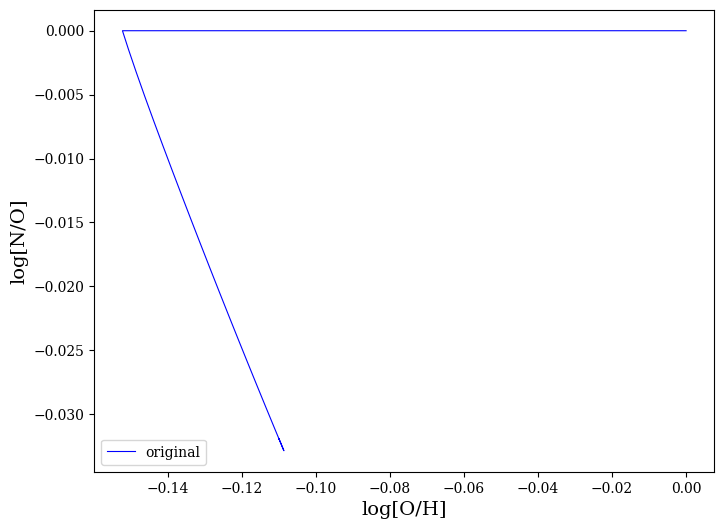

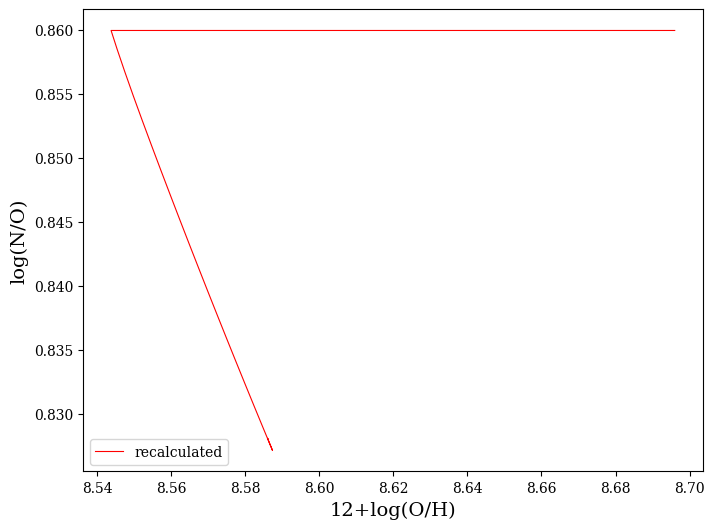

In [7]:
plt.rc('font', family='serif')
plt.figure(figsize=(8, 6))
plt.plot(logOHM5, logNOM5, color='b', lw=0.8, label='original')
plt.xlabel('log[O/H]', fontsize=14)
plt.ylabel('log[N/O]', fontsize=14)
plt.legend()
plt.savefig('logOH_logNO.png', dpi=300)
plt.show()
plt.figure(figsize=(8, 6))
logNOrecM5 = [i + 0.86 for i in logNOM5]
logOHrecM5 = [i +8.696 for i in logOHM5]
plt.plot(logOHrecM5, logNOrecM5, color='r', lw=0.8, label='recalculated')
plt.xlabel('12+log(O/H)', fontsize=14)
plt.ylabel('log(N/O)', fontsize=14)
plt.legend()
plt.savefig('logOH_logNO_recalculated.png', dpi=300)

In [16]:
pathm3 = "/home/adriana/python/galIMF/simulation_results_from_galaxy_evol/imfKroupaSTF0.097alpha1.15SFR0.1SFEN0.66Z_0-15.98/chemical_and_SN_evolution.txt"
m3 = load_data_with_names(pathm3)

# Access specific rows by name
logNOm3 = m3['Stellar mass-weighted [N/O]:']
logOHm3 = m3['Stellar mass-weighted [O/H]:']

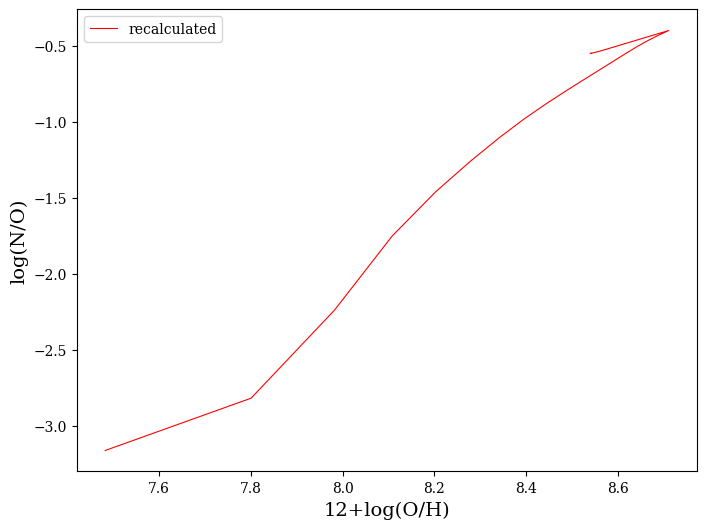

In [19]:
# plt.rc('font', family='serif')
# plt.figure(figsize=(8, 6))
# plt.plot(logOHm3, logNOm3, color='b', lw=0.8, label='original')
# plt.xlabel('log[O/H]', fontsize=14)
# plt.ylabel('log[N/O]', fontsize=14)
# plt.legend()
# plt.savefig('logOH_logNO.png', dpi=300)
# plt.show()
plt.figure(figsize=(8, 6))
logNOrecm3 = [i + 0.86 for i in logNOm3]
logOHrecm3 = [i +8.696 for i in logOHm3]
plt.plot(logOHrecm3[3:], logNOrecm3[3:], color='r', lw=0.8, label='recalculated')
plt.xlabel('12+log(O/H)', fontsize=14)
plt.ylabel('log(N/O)', fontsize=14)
plt.legend()
plt.savefig('logOH_logNO_recalculated.png', dpi=300)